In [44]:
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
from pyvis.network import Network
from networkx.algorithms import bipartite
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import stats

In [2]:
listings = pd.read_csv('listings.csv')
listings.shape

(3944, 49)

In [3]:
#To show all columns and corresponding data types
{listings.columns[i]:listings.dtypes[i] for i in range(listings.shape[1])}

{'id': dtype('int64'),
 'name': dtype('O'),
 'description': dtype('O'),
 'neighborhood_overview': dtype('O'),
 'host_id': dtype('int64'),
 'host_name': dtype('O'),
 'host_since': dtype('O'),
 'host_location': dtype('O'),
 'host_about': dtype('O'),
 'host_acceptance_rate': dtype('O'),
 'host_is_superhost': dtype('O'),
 'host_neighbourhood': dtype('O'),
 'host_total_listings_count': dtype('float64'),
 'host_verifications': dtype('O'),
 'host_identity_verified': dtype('O'),
 'neighbourhood': dtype('O'),
 'neighbourhood_cleansed': dtype('O'),
 'neighbourhood_group_cleansed': dtype('O'),
 'latitude': dtype('float64'),
 'longitude': dtype('float64'),
 'property_type': dtype('O'),
 'room_type': dtype('O'),
 'accommodates': dtype('int64'),
 'bathrooms_text': dtype('O'),
 'bedrooms': dtype('float64'),
 'beds': dtype('float64'),
 'amenities': dtype('O'),
 'price': dtype('O'),
 'minimum_nights': dtype('int64'),
 'maximum_nights': dtype('int64'),
 'has_availability': dtype('O'),
 'availability_30'

## Data Cleaning & Exploratory Data Analysis

### Listings dataset
#### Keep only listings with reviews:

In [4]:
listings = listings[listings["reviews_per_month"].notna()]

In [5]:
listings.shape

(2173, 49)

#### Convert price to float and remove $ sign:

In [6]:
def clean_price(price):
    price = price.replace('$', '')
    price = price.replace(',', '')
    return float(price)

In [7]:
listings.price = listings.price.apply(clean_price)

In [8]:
listings = listings[listings.price != 0] #Drop rows with price = $0
listings.shape

(2173, 49)

#### Keep only active listings
Assume that for a listing to be active, it must be reviewed at least once in the last 12 months and be booked for at least one night in the next 90 days.

In [9]:
print('Number of listings booked for at least 1 night in the next 90 days:', (listings.availability_90 <= 89).sum())
print('Number of listings with at least 1 review in the last 12 months:', (listings.number_of_reviews_ltm > 0).sum())

Number of listings booked for at least 1 night in the next 90 days: 1656
Number of listings with at least 1 review in the last 12 months: 944


In [10]:
# Keep only listings that have been reviewed in the last 12 months
listings = listings[listings.number_of_reviews_ltm > 0]
# Keep only listings that have at least one night booked in the next 90 days
listings = listings[listings.availability_90 < 89]
listings.shape

(722, 49)

#### Investigate most frequently occurring amenities

In [11]:
# use CountVectorizer to inspect the words in the amenities column
cvec = CountVectorizer(token_pattern='(?u)[a-zA-Z][a-z ]+', ngram_range=(1,1))
cmat = cvec.fit_transform(listings.amenities)

In [12]:
pd.DataFrame(np.array(cmat.sum(axis=0))[0],
             index=cvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:10]

,counts
wifi,713
air conditioning,710
long term stays allowed,704
essentials,684
hangers,659
iron,634
hair dryer,633
washer,623
kitchen,609
tv,584


#### Review scores

In [13]:
review_scores_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                     'review_scores_value']
listings[review_scores_cols].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,721.000000,721.000000,721.000000,721.000000,721.00000,721.000000,721.000000
mean,93.126214,9.436893,9.273232,9.678225,9.65742,9.511789,9.085992
std,9.269088,0.989794,1.004969,0.810819,0.77673,0.820018,1.097135
min,20.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
25%,90.000000,9.000000,9.000000,10.000000,10.00000,9.000000,9.000000
50%,96.000000,10.000000,10.000000,10.000000,10.00000,10.000000,9.000000
75%,100.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000
max,100.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000


In [14]:
{listings[review_scores_cols].columns[i]:listings[review_scores_cols].isnull().sum().values[i] for i in range(listings[review_scores_cols].shape[1])}

{'review_scores_rating': 1,
 'review_scores_accuracy': 1,
 'review_scores_cleanliness': 1,
 'review_scores_checkin': 1,
 'review_scores_communication': 1,
 'review_scores_location': 1,
 'review_scores_value': 1}

In [15]:
# Drop the row with null values for review scores
listings = listings[listings.review_scores_rating.notnull()]

In [16]:
listings.shape

(721, 49)

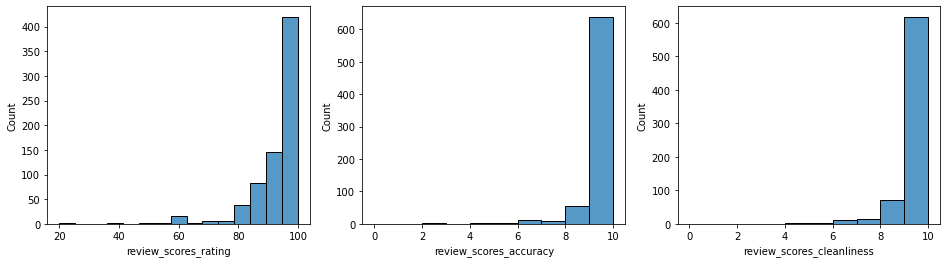

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
sns.histplot(listings.review_scores_rating, ax=ax[0], bins=15)
sns.histplot(listings.review_scores_accuracy, ax=ax[1], bins=np.linspace(0, 10, 11))
sns.histplot(listings.review_scores_cleanliness, ax=ax[2], bins=np.linspace(0, 10, 11))
plt.show()

#### Delete redundant columns:

In [18]:
listings.drop(['description','neighborhood_overview','host_name','host_since',
               'host_location','host_about','host_acceptance_rate','host_is_superhost',
               'host_neighbourhood','host_total_listings_count','host_verifications',
               'host_identity_verified','neighbourhood','latitude','longitude',
               'beds','bathrooms_text','minimum_nights', 'maximum_nights','has_availability','availability_30',
              'availability_60','number_of_reviews_l30d','calculated_host_listings_count'],axis=1,inplace=True)

In [19]:
listings.shape

(721, 25)

In [20]:
# Check for attributes with null values
{listings.columns[i]:listings.isnull().sum().values[i] for i in range(listings.shape[1])}

{'id': 0,
 'name': 0,
 'host_id': 0,
 'neighbourhood_cleansed': 0,
 'neighbourhood_group_cleansed': 0,
 'property_type': 0,
 'room_type': 0,
 'accommodates': 0,
 'bedrooms': 87,
 'amenities': 0,
 'price': 0,
 'availability_90': 0,
 'availability_365': 0,
 'number_of_reviews': 0,
 'number_of_reviews_ltm': 0,
 'first_review': 0,
 'last_review': 0,
 'review_scores_rating': 0,
 'review_scores_accuracy': 0,
 'review_scores_cleanliness': 0,
 'review_scores_checkin': 0,
 'review_scores_communication': 0,
 'review_scores_location': 0,
 'review_scores_value': 0,
 'reviews_per_month': 0}

In [21]:
# Top 10 hosts in terms of active listings count
top_host_id = listings['host_id'].value_counts().head(10)
top_host_id

66406177     35
101145755    22
23336011     19
2413412      16
10248444     15
248196938    14
287074042    14
279311966    13
8948251      13
24496358     13
Name: host_id, dtype: int64

[Text(0, 0, '66406177'),
 Text(1, 0, '101145755'),
 Text(2, 0, '23336011'),
 Text(3, 0, '2413412'),
 Text(4, 0, '10248444'),
 Text(5, 0, '248196938'),
 Text(6, 0, '287074042'),
 Text(7, 0, '279311966'),
 Text(8, 0, '8948251'),
 Text(9, 0, '24496358')]

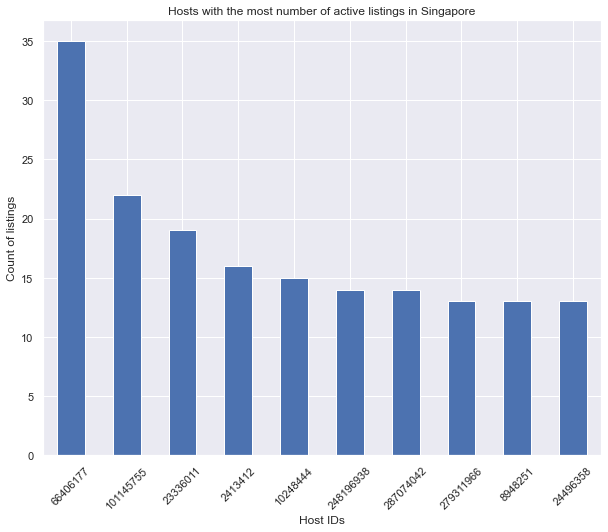

In [22]:
sns.set(rc={'figure.figsize':(10,8)})
bar_plot = top_host_id.plot(kind='bar')
bar_plot.set_title('Hosts with the most number of active listings in Singapore')
bar_plot.set_xlabel('Host IDs')
bar_plot.set_ylabel('Count of listings')
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)

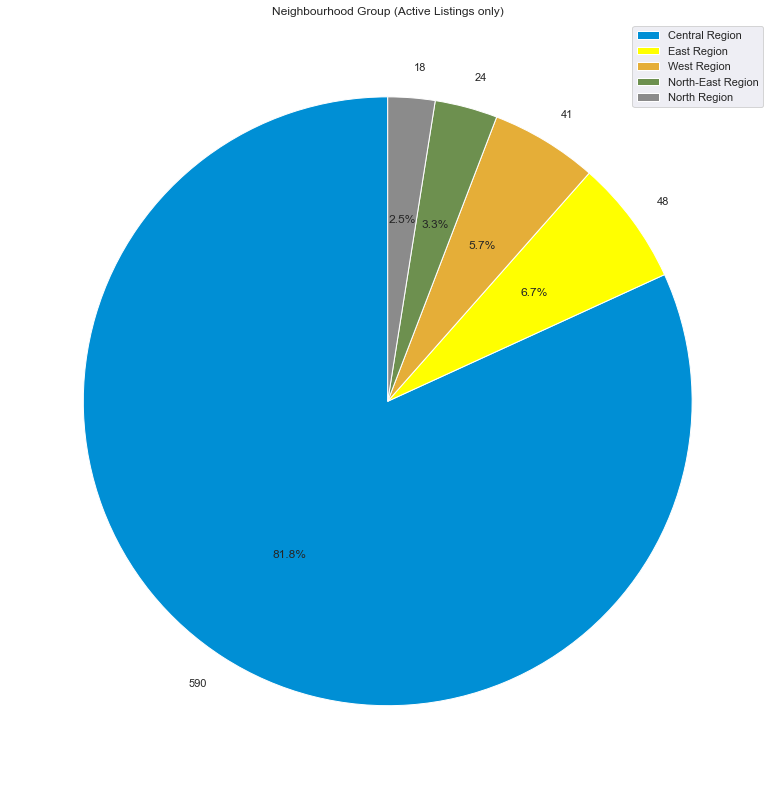

In [23]:
labels = listings.neighbourhood_group_cleansed.value_counts().index
colors = ['#008fd5','#FFFF00','#e5ae38','#6d904f','#8b8b8b']
shape = listings.neighbourhood_group_cleansed.value_counts().values
plt.figure(figsize=(14,14))
plt.pie(shape, labels=shape, colors= colors, autopct = '%1.1f%%', startangle=90)
plt.legend(labels)
plt.title('Neighbourhood Group (Active Listings only)')
plt.show()

In [24]:
listings.room_type.value_counts().index

Index(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'], dtype='object')

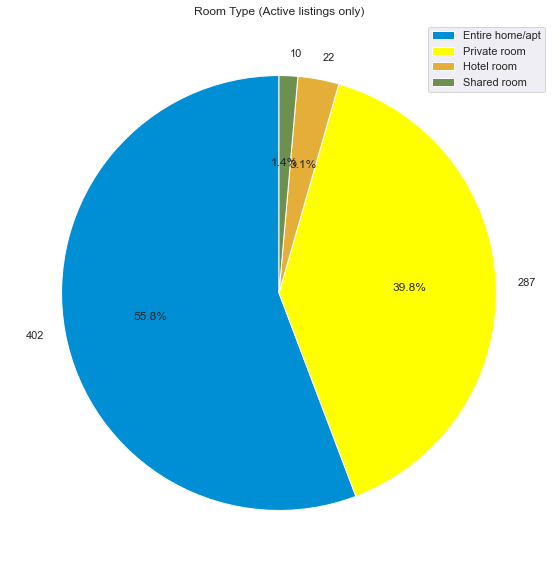

In [25]:
labels = listings.room_type.value_counts().index
colors = ['#008fd5','#FFFF00','#e5ae38','#6d904f']
shape = listings.room_type.value_counts().values
plt.figure(figsize=(10,10))
plt.pie(shape, labels=shape, colors= colors, autopct = '%1.1f%%', startangle=90)
plt.legend(labels)
plt.title('Room Type (Active listings only)')
plt.show()

As the hotel room and shared room dataset is very small, we will instead focus on entire home and private room datasets.

### Split data based on room type

In [26]:
private_room = listings[listings.room_type == 'Private room']
entire_home = listings[listings.room_type == 'Entire home/apt']
hotel_room = listings[listings.room_type == 'Hotel room']
shared_room = listings[listings.room_type == 'Shared room']

In [27]:
private_room.to_csv('listings_private room.csv')
entire_home.to_csv('listings_entire home.csv')
hotel_room.to_csv('listings_hotel room.csv')
shared_room.to_csv('listings_shared room.csv')

#### Top 10 neighbourhoods of Airbnb listings

In [28]:
top_ten_neighbourhood = listings.neighbourhood_cleansed.value_counts().head(10)

[Text(0, 0, 'Kallang'),
 Text(1, 0, 'Outram'),
 Text(2, 0, 'Rochor'),
 Text(3, 0, 'Geylang'),
 Text(4, 0, 'Novena'),
 Text(5, 0, 'Downtown Core'),
 Text(6, 0, 'River Valley'),
 Text(7, 0, 'Bukit Merah'),
 Text(8, 0, 'Bedok'),
 Text(9, 0, 'Queenstown')]

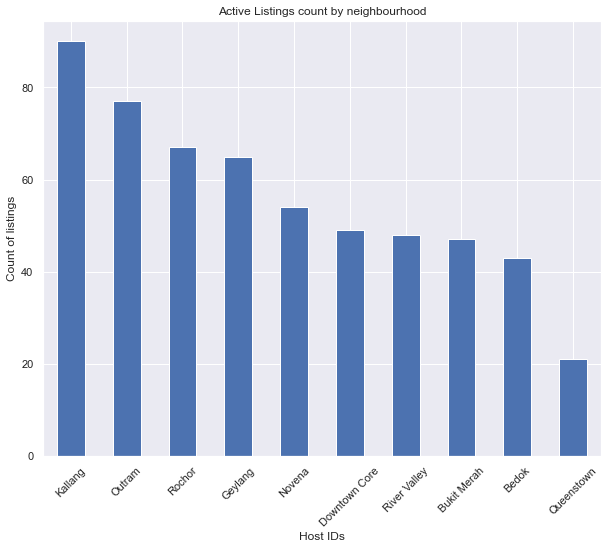

In [29]:
sns.set(rc={'figure.figsize':(10,8)})
bar_plot = top_ten_neighbourhood.plot(kind='bar')
bar_plot.set_title('Active Listings count by neighbourhood')
bar_plot.set_xlabel('Host IDs')
bar_plot.set_ylabel('Count of listings')
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)

#### Top listing words

In [30]:
#Create empty list where we are going to put the name strings
names = []
#Getting name string from 'name' column and appending it to the empty list
for name in listings.name:
    names.append(name)

names_count = []
#Getting name string to appending it to the names_count list
for n in names:
    for word in str(n).split():
        word = word.lower()
        names_count.append(word)

In [31]:
stop_words = set(stopwords.words('english'))
#Remove stop words
names_count = [w for w in names_count if not w.lower() in stop_words]
#Remove non-english words
names_count = [w for w in names_count if w.isalpha()]

In [32]:
top_25 = Counter(names_count).most_common()
top_25 = top_25[:25]

In [65]:
top_25

[('allowed', 13),
 ('on', 11),
 ('Long', 10),
 ('term', 10),
 ('stays', 10),
 ('Essentials', 10),
 ('Wifi', 10),
 ('Kitchen', 10),
 ('Shampoo', 9),
 ('parking', 9),
 ('Air', 9),
 ('conditioning', 9),
 ('Hair', 9),
 ('dryer', 9),
 ('Lock', 8),
 ('bedroom', 8),
 ('door', 8),
 ('Iron', 8),
 ('Dedicated', 7),
 ('workspace', 7),
 ('Hangers', 7),
 ('Hot', 7),
 ('water', 7),
 ('Washer', 7),
 ('Paid', 6)]

[Text(0, 0, 'allowed'),
 Text(1, 0, 'on'),
 Text(2, 0, 'Long'),
 Text(3, 0, 'term'),
 Text(4, 0, 'stays'),
 Text(5, 0, 'Essentials'),
 Text(6, 0, 'Wifi'),
 Text(7, 0, 'Kitchen'),
 Text(8, 0, 'Shampoo'),
 Text(9, 0, 'parking'),
 Text(10, 0, 'Air'),
 Text(11, 0, 'conditioning'),
 Text(12, 0, 'Hair'),
 Text(13, 0, 'dryer'),
 Text(14, 0, 'Lock'),
 Text(15, 0, 'bedroom'),
 Text(16, 0, 'door'),
 Text(17, 0, 'Iron'),
 Text(18, 0, 'Dedicated'),
 Text(19, 0, 'workspace'),
 Text(20, 0, 'Hangers'),
 Text(21, 0, 'Hot'),
 Text(22, 0, 'water'),
 Text(23, 0, 'Washer'),
 Text(24, 0, 'Paid')]

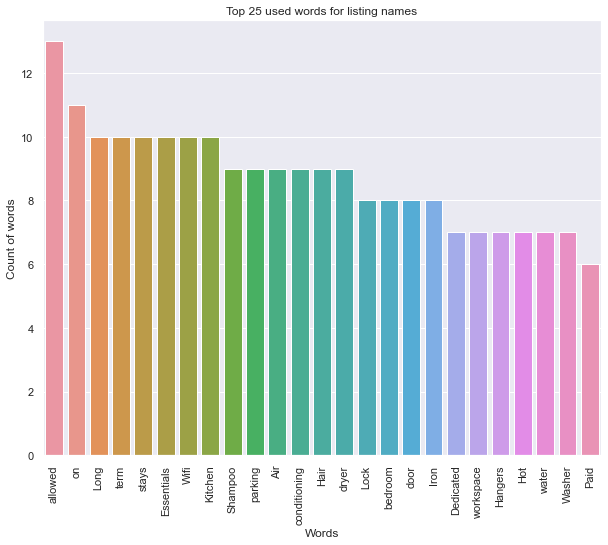

In [66]:
word_count_data = pd.DataFrame(top_25)
word_count_data.rename(columns={0:'Words',1:'Counts'},inplace=True)

viz_count = sns.barplot(x='Words',y='Counts', data = word_count_data)
viz_count.set_title('Top 25 used words for listing names')
viz_count.set_ylabel('Count of words')
viz_count.set_xlabel('Words')
viz_count.set_xticklabels(viz_count.get_xticklabels(),rotation = 90)

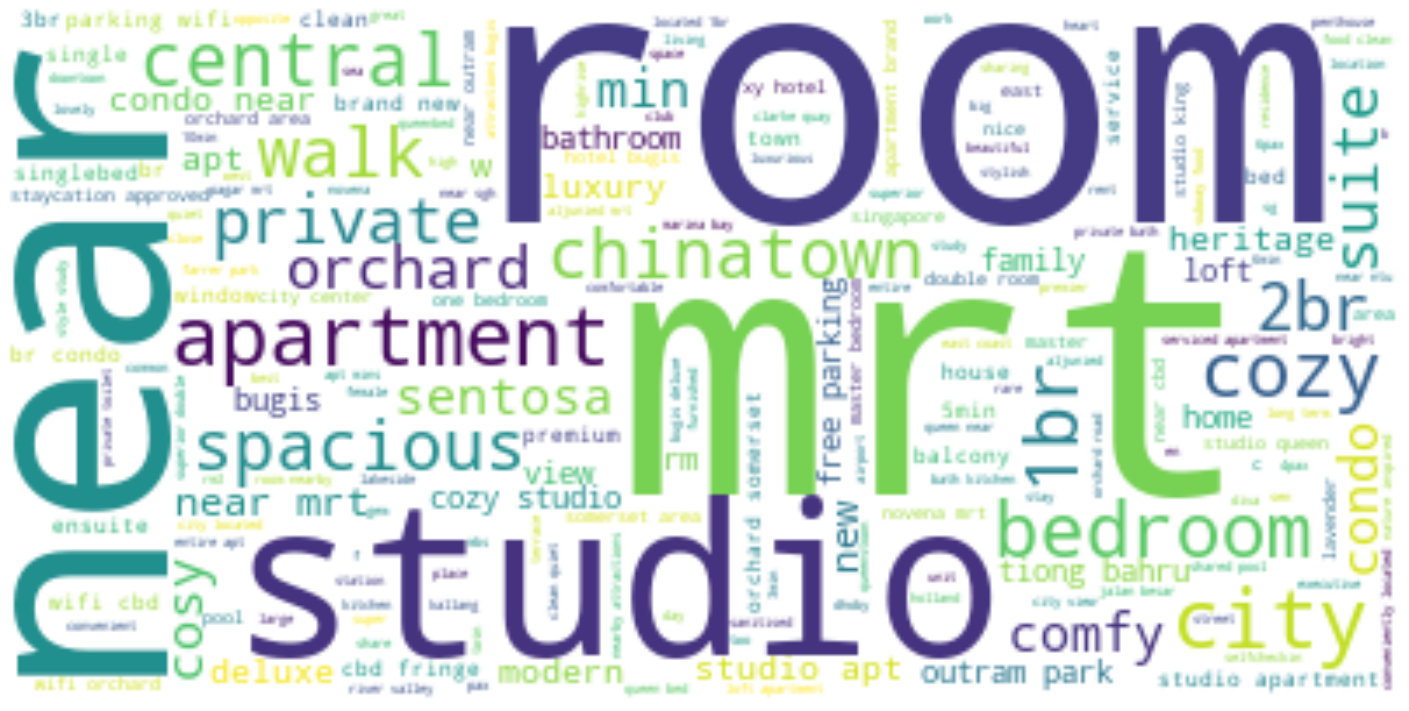

In [35]:
text = ' '.join(str(n).lower() for n in listings.name)
#Generate wordcloud image
wordcloud = WordCloud(max_words=200, background_color = 'white').generate(text)
plt.figure(figsize=(25,20))
#Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Create top 10 listings for each category based on number of reviews

In [55]:
#Top 10 private room
top_ten_private_room = private_room.nlargest(10,'number_of_reviews').sort_values(by='number_of_reviews',ascending=False)

In [56]:
#Top 10 entire home
top_ten_entire_home = entire_home.nlargest(10,'number_of_reviews').sort_values(by='number_of_reviews',ascending=False)

#### Top 10 most reviewed listings

In [36]:
listings.nlargest(10, 'number_of_reviews')

,id,name,host_id,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bedrooms,amenities,...,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
56,2129215,Luxuriously Spacious Studio Apt.,7642747,Bedok,East Region,Entire townhouse,Entire home/apt,5,1.0,"[""Hair dryer"", ""Kitchen"", ""Free street parking...",...,14/1/2014,31/3/2020,99.0,10.0,10.0,10.0,10.0,10.0,10.0,4.22
394,10848771,Spacious room near Woodleigh MRT,44793532,Toa Payoh,Central Region,Private room in house,Private room,2,1.0,"[""Cooking basics"", ""Microwave"", ""Shower gel"", ...",...,1/3/2016,2/4/2020,97.0,10.0,10.0,10.0,10.0,9.0,10.0,5.73
144,5377342,S5 @ City Central,25116861,Rochor,Central Region,Entire apartment,Entire home/apt,2,1.0,"[""Hangers"", ""Hair dryer"", ""Iron"", ""Fire exting...",...,27/2/2015,13/2/2021,95.0,10.0,10.0,10.0,10.0,10.0,9.0,3.93
78,3753251,Relaxed & Spacious Studio w JACUZZI,10248444,River Valley,Central Region,Entire apartment,Entire home/apt,5,1.0,"[""Cooking basics"", ""Microwave"", ""Elevator"", ""S...",...,23/9/2014,3/1/2021,91.0,9.0,9.0,9.0,9.0,9.0,8.0,3.63
460,12484261,"City room 5mins to Haji, near Suntec/MBS/Merlion",3234859,Kallang,Central Region,Private room in apartment,Private room,2,1.0,"[""Hair dryer"", ""Heating"", ""Kitchen"", ""Keypad"",...",...,5/2/2017,17/2/2021,97.0,9.0,9.0,10.0,10.0,10.0,9.0,5.42
31,982909,Cozy Room @Central Area,4723385,Novena,Central Region,Private room in apartment,Private room,1,1.0,"[""Coffee maker"", ""Hair dryer"", ""Heating"", ""Kit...",...,5/4/2013,30/7/2020,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2.54
140,5355795,S2 @ City Central,25116861,Rochor,Central Region,Entire apartment,Entire home/apt,2,1.0,"[""Hangers"", ""Hair dryer"", ""Iron"", ""Fire exting...",...,25/2/2015,1/1/2021,94.0,10.0,9.0,10.0,10.0,10.0,9.0,3.28
439,12162272,"Great location. A spacious, well equipped home.",65322694,Kallang,Central Region,Entire apartment,Entire home/apt,4,1.0,"[""Hair dryer"", ""Kitchen"", ""Washer \u2013\u00a0...",...,6/7/2016,30/1/2021,97.0,10.0,9.0,10.0,10.0,10.0,10.0,4.22
142,5376240,S6 @ City Central,25116861,Rochor,Central Region,Entire apartment,Entire home/apt,2,1.0,"[""Refrigerator"", ""First aid kit"", ""Shower gel""...",...,5/3/2015,27/2/2021,96.0,9.0,10.0,10.0,10.0,10.0,9.0,3.22
684,16891958,"Apt Room 5mins to Haji, near MBS/Suntec/Sportshub",3234859,Kallang,Central Region,Private room in apartment,Private room,2,1.0,"[""Hair dryer"", ""Kitchen"", ""Keypad"", ""Washer"", ...",...,25/1/2017,18/10/2020,95.0,10.0,9.0,10.0,10.0,10.0,9.0,4.59


### Reviews dataset

In [37]:
reviews = pd.read_csv('reviews.csv')
reviews.shape

(53675, 6)

In [38]:
# drop empty comments
reviews.dropna(inplace=True)
reviews.shape

(53574, 6)

In [39]:
# drop reviews containing 'This is an automated posting'
automated = reviews[reviews.comments.str.contains('This is an automated posting')].index
reviews.drop(index=automated, inplace=True)
reviews.shape

(53024, 6)

In [40]:
# # Drop reviews containing non-ASCII characters 
# reviews = reviews[reviews['comments'].map(lambda x: x.isascii())]
# reviews.shape

In [41]:
from langdetect import detect

In [42]:
def detect_language(review):
    try:
        return detect(review)
    except:
        return np.nan

In [43]:
reviews['language'] = reviews.comments.map(detect_language)

In [44]:
(reviews['language'] != 'en').sum()

8967

In [45]:
(reviews['language'] == 'en').sum()

44057

In [46]:
# Keep only reviews in English
reviews = reviews[reviews.language == 'en']
reviews.shape

(44057, 7)

In [47]:
reviews.to_csv('reviews_cleaned.csv')

## Merge Data

In [47]:
# create subsets with relevant columns for merging
df1 = reviews[['listing_id', 'reviewer_id', 'reviewer_name', 'id', 'date', 'comments']].copy()
df2 = private_room[['id', 'host_id']].copy()
df3 = entire_home[['id', 'host_id']].copy()

In [48]:
# rename id in listings dataset as listing_id for merge
df2.rename(columns={'id': 'listing_id'}, inplace=True)
df3.rename(columns={'id': 'listing_id'}, inplace=True)

# rename id in reviews dataset as review_id
df1.rename(columns={'id': 'review_id'}, inplace=True)

In [61]:
pr_merged = pd.merge(df2, df1, how='left', on='listing_id')
pr_merged.shape

(6623, 7)

In [62]:
eh_merged = pd.merge(df3, df1, how='left', on='listing_id')
eh_merged.shape

(10601, 7)

In [63]:
# merge reviews dataset with private_room dataset
private_room_merged = pd.merge(df1, df2, how='left', on='listing_id')
private_room_merged.dropna(inplace=True)
private_room_merged.shape

(6614, 7)

In [64]:
# merge reviews dataset with entire_home dataset
entire_home_merged = pd.merge(df1, df3, how='left', on='listing_id')
entire_home_merged.dropna(inplace=True)
entire_home_merged.shape

(10588, 7)

In [65]:
private_room_merged_count = private_room_merged.groupby('listing_id')[['review_id']].count().sort_values(by='review_id', ascending=False).reset_index()
entire_home_merged_count = entire_home_merged.groupby('listing_id')[['review_id']].count().sort_values(by='review_id', ascending=False).reset_index()

In [66]:
private_room_merged_count.to_csv('private_room_merged_count.csv')
entire_home_merged_count.to_csv('entire_home_merged_count.csv')

In [67]:
pr_merged_count = pr_merged.groupby('listing_id')[['review_id']].count().sort_values(by='review_id', ascending=False).reset_index()
eh_merged_count = eh_merged.groupby('listing_id')[['review_id']].count().sort_values(by='review_id', ascending=False).reset_index()

In [68]:
pr_merged_count.to_csv('pr_merged_count.csv')
eh_merged_count.to_csv('eh_merged_count.csv')

In [69]:
private_room_merged.to_csv('private_room merged.csv')
entire_home_merged.to_csv('entire_home merged.csv')

## Network Analysis

In [66]:
private_room_merged.head()

,listing_id,reviewer_id,reviewer_name,review_id,date,comments,host_id
138,275343,5492044,Carol,4223592,2013-04-20,A newly renovated and clean apartment. Conveni...,1439258.0
139,275343,7938877,Ying,8818243,2013-11-19,I am so glad that i chose the place. Joyce and...,1439258.0
140,275343,18071761,誼勳,26820048,2015-02-20,I enjoyed the time shared with the Woons. Joyc...,1439258.0
141,275343,26579851,David,28258248,2015-03-21,"The Woons are nice welcoming people, I had a g...",1439258.0
142,275343,29892169,Jessica,34945181,2015-06-14,I stayed with the Woon family for 3 weeks in M...,1439258.0


In [70]:
G = nx.Graph()
G.add_nodes_from(private_room_merged.review_id.unique(), bipartite=0)
G.add_nodes_from(private_room_merged.listing_id.unique(), bipartite=1)
G.add_edges_from(private_room_merged[['review_id', 'listing_id']].values)

In [71]:
G2 = nx.Graph()
G2.add_nodes_from(entire_home_merged.review_id.unique(), bipartite=0)
G2.add_nodes_from(entire_home_merged.listing_id.unique(), bipartite=1)
G2.add_edges_from(entire_home_merged[['review_id', 'listing_id']].values)

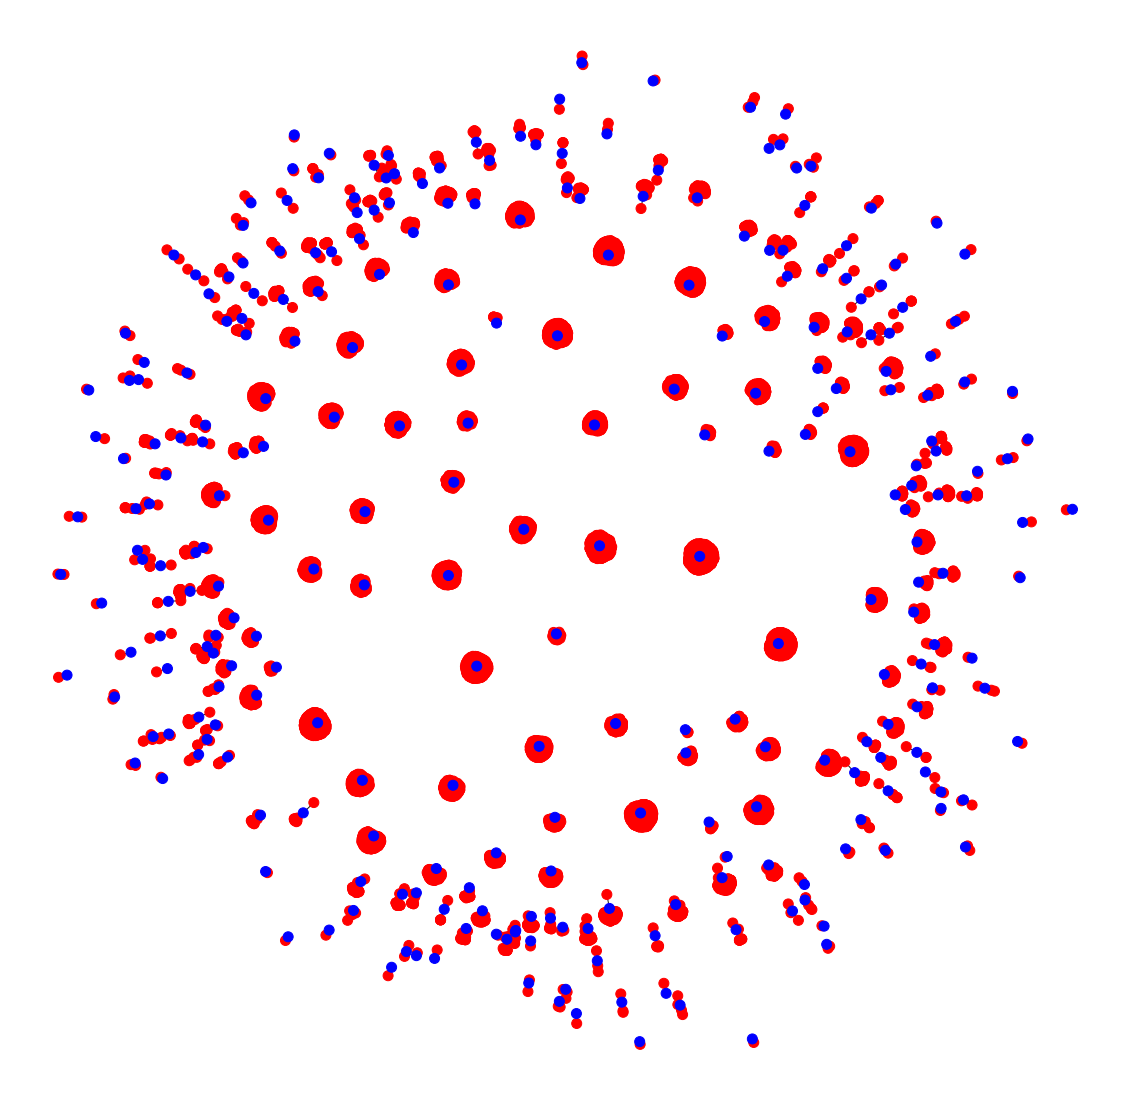

In [72]:
# nodes
review_nodes = private_room_merged.review_id.unique()
listing_nodes = private_room_merged.listing_id.unique()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=1)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(review_nodes) +
        ['blue']*(len(listing_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

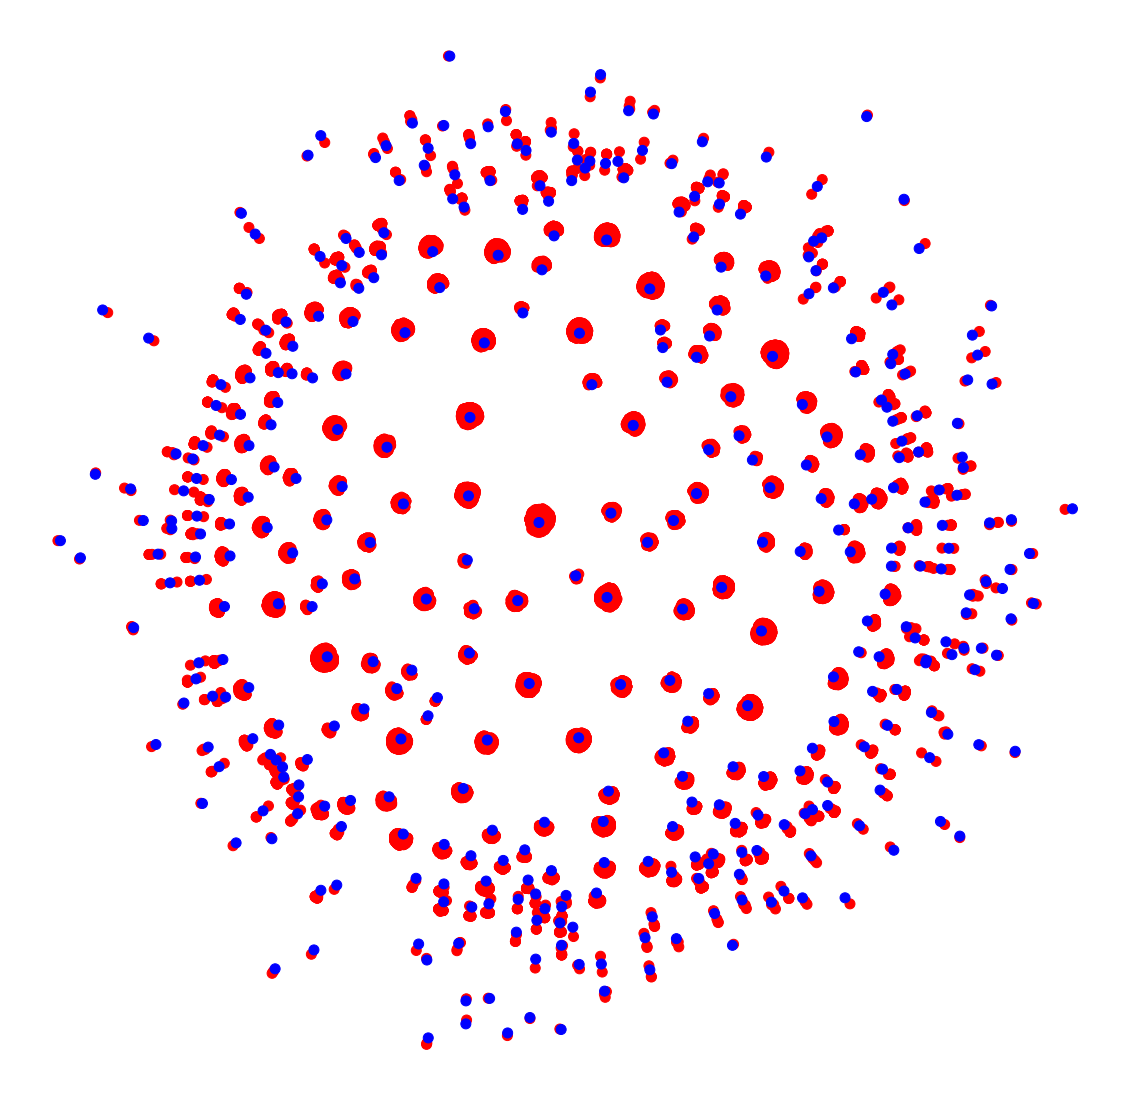

In [73]:
# nodes
review_nodes = entire_home_merged.review_id.unique()
listing_nodes = entire_home_merged.listing_id.unique()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G2, seed=1)
nx.draw_networkx_nodes(G2, pos, node_size=100, node_color=['red']*len(review_nodes) +
        ['blue']*(len(listing_nodes)))
nx.draw_networkx_edges(G2, pos, width=1)
plt.axis("off")
plt.show()

#### Remove listings with only 1 review from graph

In [74]:
def component_size_two(G):
    '''Take a graph G and return a list of the 
       connected components of size 2 and the
       number of connected components of size 2'''
    components = [list(G) for G in nx.connected_components(G) if len(G) == 2]
    num_components = len(components)
    return components, num_components

In [75]:
# identify the components with only one link (For G)
components_two, n_two = component_size_two(G)
components_two = [item for sublist in components_two for item in sublist]

print("Number of components:\n", n_two)

Number of components:
 49


In [76]:
# remove the listings with only 1 link from the graph G
G.remove_nodes_from(components_two)

In [77]:
# identify the components with only one link (For G2)
components_two, n_two = component_size_two(G2)
components_two = [item for sublist in components_two for item in sublist]

print("Number of components:\n", n_two)

Number of components:
 63


In [78]:
# remove the listings with only 1 link from the graph G2
G2.remove_nodes_from(components_two)

### Calculate centrality scores for 2 bipartite graphs

In [93]:
import operator

# define a function to print top K nodes for a given centrality measure
def print_top_nodes(scores, k):
    '''
    scores: centrality scores computed by networkx (should be a dictionary)
    k: top K nodes to print
    '''
    # sort nodes by scores
    scores_sorted = reversed(sorted(scores.items(), key = operator.itemgetter(1))[-k:])
    for item in scores_sorted:
        print(item[0],'\t', item[1])

In [80]:
# Private room dataset
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)
pagerank = nx.pagerank(G)

In [81]:
print('Top 10 by Degree Centrality - Private room')
print_top_nodes(degree, 10)

Top 10 by Degree Centrality - Private room
10848771 	 0.04121890181068748
982909 	 0.03076696599440601
12484261 	 0.030325334903577215
11972403 	 0.02767554835860445
9980935 	 0.02590902399528927
16891958 	 0.0237008685411453
43337094 	 0.023259237450316505
42078904 	 0.023259237450316505
25972498 	 0.02208155454143972
25998215 	 0.021639923450610925


In [82]:
print('Top 10 by Betweenness Centrality - Private room')
print_top_nodes(betweenness, 10)

Top 10 by Betweenness Centrality - Private room
10848771 	 0.0016931792704920207
982909 	 0.0009422156841631992
12484261 	 0.0009152964745632109
11972403 	 0.0007619740198850164
9980935 	 0.0006675617195488254
16891958 	 0.0005583243472590176
43337094 	 0.0005376472732184468
42078904 	 0.0005376472732184468
25972498 	 0.00048441572830896904
25998215 	 0.0004651691436674315


In [83]:
print('Top 10 by Eigenvector Centrality - Private room')
print_top_nodes(eigenvector, 10)

Top 10 by Eigenvector Centrality - Private room
10848771 	 0.7072695330214538
621572120 	 0.0422479839545152
618935622 	 0.0422479839545152
612665802 	 0.0422479839545152
605238463 	 0.0422479839545152
603278095 	 0.0422479839545152
596549824 	 0.0422479839545152
594615788 	 0.0422479839545152
592478397 	 0.0422479839545152
590602816 	 0.0422479839545152


In [84]:
print('Top 10 by PageRank Centrality - Private room')
print_top_nodes(pagerank, 10)

Top 10 by PageRank Centrality - Private room
10848771 	 0.019079071716898245
982909 	 0.014261280697219656
12484261 	 0.014057712062585367
11972403 	 0.012836300254779567
9980935 	 0.012022025716242456
16891958 	 0.011004182543070878
43337094 	 0.010800613908436691
42078904 	 0.010800613908436691
25972498 	 0.01025776421607845
25998215 	 0.01005419558144416


In [85]:
# Entire Home dataset
degree = nx.degree_centrality(G2)
betweenness = nx.betweenness_centrality(G2)
eigenvector = nx.eigenvector_centrality(G2)
pagerank = nx.pagerank(G2)

In [94]:
print('Top 10 by Degree Centrality - Entire Home')
print_top_nodes(degree, 10)

Top 10 by Degree Centrality - Entire Home
2129215 	 0.02663594470046083
3753251 	 0.02294930875576037
5377342 	 0.021382488479262673
1024986 	 0.01935483870967742
5376240 	 0.01806451612903226
5355795 	 0.017511520737327188
12162272 	 0.016682027649769584
5377148 	 0.01576036866359447
5376182 	 0.015576036866359447
25793757 	 0.01511520737327189


In [95]:
print('Top 10 by Betweenness Centrality - Entire Home')
print_top_nodes(betweenness, 10)

Top 10 by Betweenness Centrality - Entire Home
2129215 	 0.0007070837933203723
3753251 	 0.0005246039793002647
5377342 	 0.0004552820387786596
1024986 	 0.00037286029037907466
5376240 	 0.00032469173611957697
5355795 	 0.000305067510310152
12162272 	 0.0002767780419355264
5377148 	 0.00024695941310821825
5376182 	 0.0002411995754031143
25793757 	 0.0002270973178950427


In [96]:
print('Top 10 by Eigenvector Centrality - Entire Home')
print_top_nodes(eigenvector, 10)

Top 10 by Eigenvector Centrality - Entire Home
2129215 	 0.7069637407989728
621385358 	 0.04160144589105718
619324511 	 0.04160144589105718
618255050 	 0.04160144589105718
613470602 	 0.04160144589105718
602821495 	 0.04160144589105718
599425498 	 0.04160144589105718
596137201 	 0.04160144589105718
595364939 	 0.04160144589105718
594197263 	 0.04160144589105718


In [97]:
print('Top 10 by PageRank Centrality - Entire Home')
print_top_nodes(pagerank, 10)

Top 10 by PageRank Centrality - Entire Home
2129215 	 0.012219591808053007
3753251 	 0.010535225918718923
5377342 	 0.009819370415751925
1024986 	 0.008892969176618127
5376240 	 0.008303441115351189
5355795 	 0.008050786231951103
12162272 	 0.007671803906850934
5377148 	 0.0072507124345174085
5376182 	 0.007166494140050669
25793757 	 0.006955948403883917


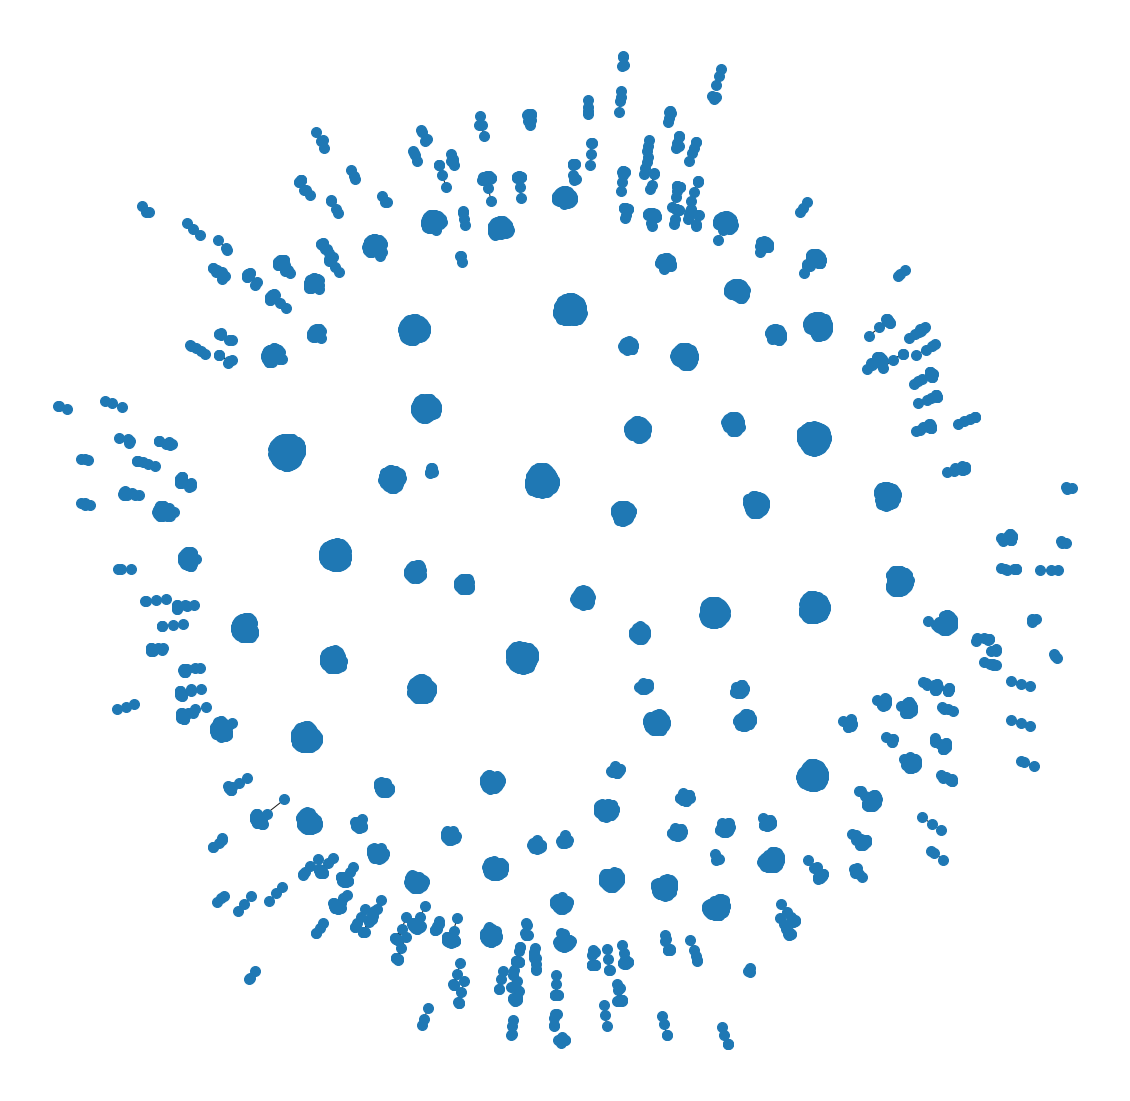

In [82]:
# remove the listings with only 1 link, plot the remaining ones
G.remove_nodes_from(components_two)

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=1)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(review_nodes) +
        ['blue']*(len(listing_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=11, font_family="sans-serif")
plt.axis("off")
plt.show()

In [87]:
private_room_listing = private_room_merged.groupby('listing_id')[['review_id']].count().reset_index()

In [88]:
private_room_listing[private_room_listing.review_id > 1].review_id.count() # Number of listings with more than 1 review

229

In [89]:
entire_home_listing = entire_home_merged.groupby('listing_id')[['review_id']].count().reset_index()

In [90]:
entire_home_listing[entire_home_listing.review_id > 1].review_id.count() # Number of listings with more than 1 review

326

#### Calculate number of reviews per reviewer

In [60]:
reviewer_review_counts_private = private_room_merged.groupby('reviewer_id')[['listing_id']].count().reset_index()
reviewer_review_counts_private.rename(columns={'listing_id': 'reviewer_review_count'}, inplace=True)
reviewer_review_counts_private[reviewer_review_counts_private.reviewer_review_count>1]

,reviewer_id,reviewer_review_count
1,92845,3
3,165502,4
17,449228,2
26,616545,2
46,941179,2
...,...,...
6186,365732872,2
6222,374184233,2
6233,375980153,2
6239,377042490,2


## Top listing words (private room)

### All listing names

In [50]:
#Create empty list where we are going to put the name strings
names = []
#Getting name string from 'name' column and appending it to the empty list
for name in private_room.name:
    names.append(name)

names_count = []
#Getting name string to appending it to the names_count list
for n in names:
    for word in str(n).split():
        word = word.lower()
        names_count.append(word)

In [103]:
stop_words = set(stopwords.words('english'))
#Remove stop words
names_count = [w for w in names_count if not w.lower() in stop_words]
#Remove non-english words
names_count = [w for w in names_count if w.isalpha()]

In [54]:
top_25 = Counter(names_count).most_common()
top_25 = top_25[:25]

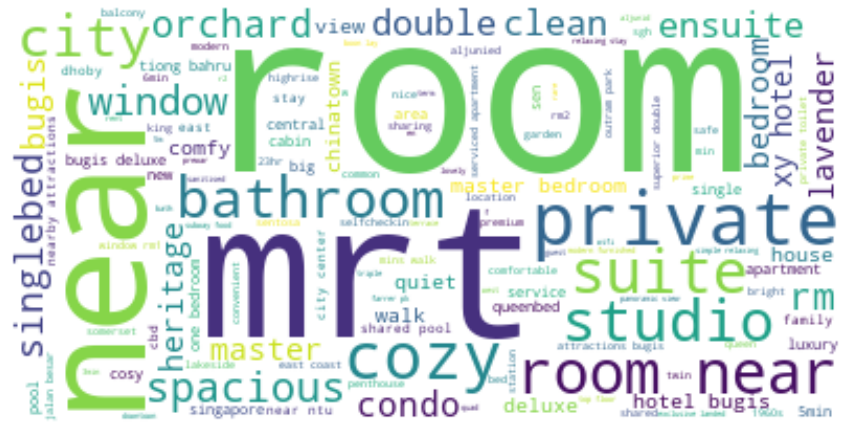

In [105]:
text = ' '.join(str(n).lower() for n in private_room.name)
#Generate wordcloud image
wordcloud = WordCloud(max_words=200, background_color = 'white').generate(text)
plt.figure(figsize=(15,10))
#Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [48]:
#Create empty list where we are going to put the name strings
names = []
#Getting name string from 'name' column and appending it to the empty list
for name in top_ten_private_room.name:
    names.append(name)

names_count = []
#Getting name string to appending it to the names_count list
for n in names:
    for word in str(n).split():
        word = word.lower()
        names_count.append(word)

In [49]:
stop_words = set(stopwords.words('english'))
#Remove stop words
names_count = [w for w in names_count if not w.lower() in stop_words]
#Remove non-english words
names_count = [w for w in names_count if w.isalpha()]
top_25 = Counter(names_count).most_common()
top_25 = top_25[:25]

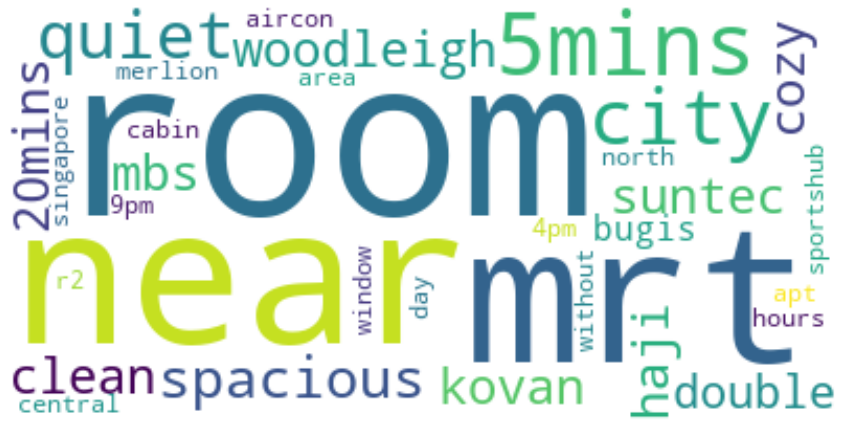

In [50]:
text = ' '.join(str(n).lower() for n in top_ten_private_room.name)
#Generate wordcloud image
wordcloud = WordCloud(max_words=200, background_color = 'white').generate(text)
plt.figure(figsize=(15,10))
#Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Top listing words (entire home)

In [106]:
#Create empty list where we are going to put the name strings
names = []
#Getting name string from 'name' column and appending it to the empty list
for name in entire_home.name:
    names.append(name)

names_count = []
#Getting name string to appending it to the names_count list
for n in names:
    for word in str(n).split():
        word = word.lower()
        names_count.append(word)

In [107]:
stop_words = set(stopwords.words('english'))
#Remove stop words
names_count = [w for w in names_count if not w.lower() in stop_words]
#Remove non-english words
names_count = [w for w in names_count if w.isalpha()]

In [108]:
top_25 = Counter(names_count).most_common()
top_25 = top_25[:25]

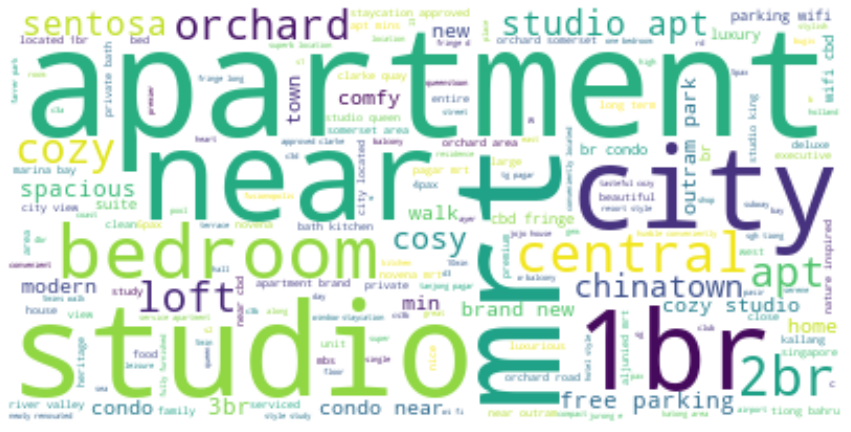

In [109]:
text = ' '.join(str(n).lower() for n in entire_home.name)
#Generate wordcloud image
wordcloud = WordCloud(max_words=200, background_color = 'white').generate(text)
plt.figure(figsize=(15,10))
#Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [51]:
#Create empty list where we are going to put the name strings
names = []
#Getting name string from 'name' column and appending it to the empty list
for name in top_ten_entire_home.name:
    names.append(name)

names_count = []
#Getting name string to appending it to the names_count list
for n in names:
    for word in str(n).split():
        word = word.lower()
        names_count.append(word)

In [52]:
stop_words = set(stopwords.words('english'))
#Remove stop words
names_count = [w for w in names_count if not w.lower() in stop_words]
#Remove non-english words
names_count = [w for w in names_count if w.isalpha()]
top_25 = Counter(names_count).most_common()
top_25 = top_25[:25]

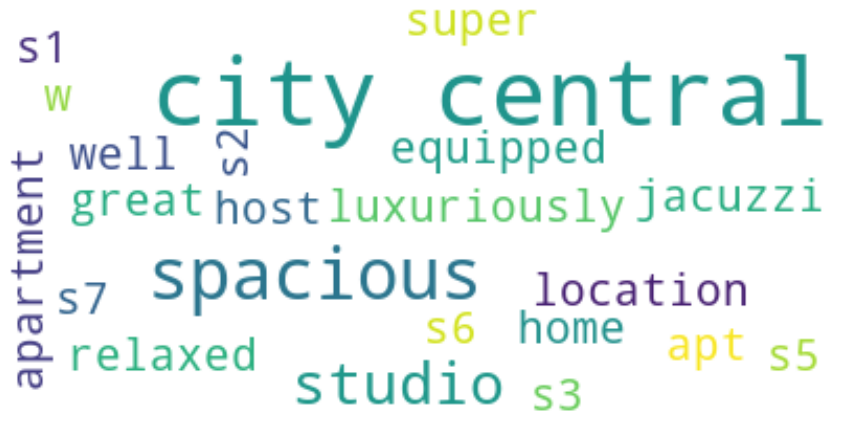

In [53]:
text = ' '.join(str(n).lower() for n in top_ten_entire_home.name)
#Generate wordcloud image
wordcloud = WordCloud(max_words=200, background_color = 'white').generate(text)
plt.figure(figsize=(15,10))
#Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Plot bar graph of amenities for top 10 listings 

In [57]:
from ast import literal_eval
# Change to parsable literal string format in dataframe column
top_ten_private_room['amenities'] = top_ten_private_room['amenities'].apply(lambda x: literal_eval(x))
# Convert to list of lists
pr_list = top_ten_private_room['amenities'].to_list()

In [58]:
sns.set(rc={'figure.figsize':(10,8)})
lst = [item for sublist in pr_list for item in sublist]

In [86]:
# word_counts = Counter(lst)

In [89]:
# df = pd.DataFrame.from_dict(word_counts,orient='index').reset_index().sort_values(by=0,ascending=False)
# df.rename(columns={'index':'Amenities',0:'Counts'},inplace=True)

In [90]:
word_counts = Counter(lst).most_common()
word_count_pr = pd.DataFrame(word_counts)
word_count_pr.rename(columns={0:'Amenities',1:'Counts'},inplace=True)

Text(0.5, 0, 'Count of amenities')

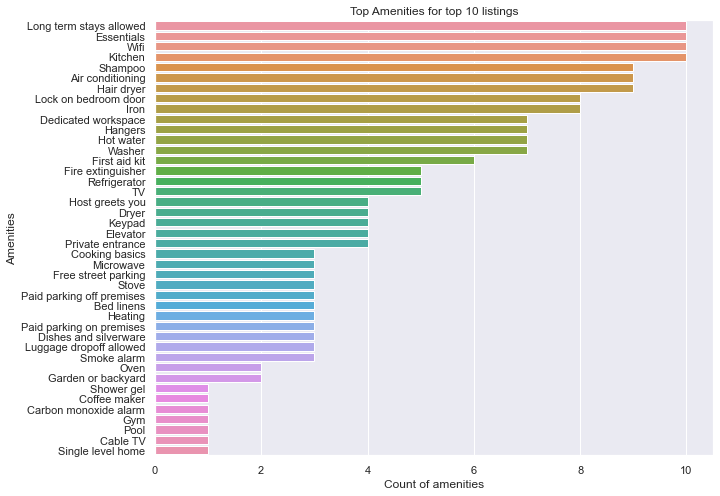

In [92]:
viz_count = sns.barplot(x='Counts',y='Amenities', data = word_count_pr)
viz_count.set_title('Top Amenities for top 10 listings')
viz_count.set_ylabel('Amenities')
viz_count.set_xlabel('Count of amenities')